# ЛР2
Датасет: https://www.kaggle.com/datasets/yaminh/smartphone-sale-dataset

In [9]:
!pip install kagglehub seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline
sns.set_style('whitegrid')

# Загрузка датасета

In [10]:
import kagglehub

path = kagglehub.dataset_download("yaminh/smartphone-sale-dataset")

df = pd.read_csv(f"{path}/Sales.csv")
df.head()

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage
0,SAMSUNG,GALAXY M31S,Mirage Black,8 GB,128 GB,Yes,4.3,19330,20999,SAMSUNG GALAXY M31S,1669,7.947998
1,Nokia,3.2,Steel,2 GB,16 GB,Yes,3.8,10199,10199,Nokia 3.2,0,0.000000
2,realme,C2,Diamond Black,2 GB,NaN,Yes,4.4,6999,7999,realme C2,1000,12.501563
3,Infinix,Note 5,Ice Blue,4 GB,64 GB,Yes,4.2,12999,12999,Infinix Note 5,0,0.000000
4,Apple,iPhone 11,Black,4GB,64 GB,Yes,4.6,49900,49900,Apple iPhone 11,0,0.000000


# Добавить новые атрибуты

In [11]:
df['RAM_GB'] = df['Memory'].str.extract(r'(\d+)').astype(float)
df['Storage_GB'] = df['Storage'].str.extract(r'(\d+)').astype(float)
df['total_storage_GB'] = df['RAM_GB'] + df['Storage_GB']
df['value_score'] = df['Rating'] / df['Selling Price']
df.sample(5)

,Brands,Models,Colors,Memory,Storage,Camera,Rating,Selling Price,Original Price,Mobile,Discount,discount percentage,RAM_GB,Storage_GB,total_storage_GB,value_score
935,SAMSUNG,Galaxy A7,Black,6 GB,128 GB,Yes,4.4,24600,24600,SAMSUNG Galaxy A7,0,0.000000,6.0,128.0,134.0,0.000179
2443,Infinix,Smart 2,Serene Gold,2 GB,16 GB,Yes,4.1,6949,6999,Infinix Smart 2,50,0.714388,2.0,16.0,18.0,0.000590
164,realme,X2 Pro,Lunar White,12 GB,256 GB,Yes,4.6,35999,35999,realme X2 Pro,0,0.000000,12.0,256.0,268.0,0.000128
2142,SAMSUNG,Galaxy On Nxt,Gold,3 GB,16 GB,Yes,4.3,11200,11200,SAMSUNG Galaxy On Nxt,0,0.000000,3.0,16.0,19.0,0.000384
2821,OPPO,F1 Plus,Gold,4 GB,64 GB,Yes,4.0,27500,27500,OPPO F1 Plus,0,0.000000,4.0,64.0,68.0,0.000145


## "Причесать" датасет

In [12]:
# Удаляем дубликаты
df.drop_duplicates(inplace=True)

# Заполняем пропуски медианой
for col in ['RAM_GB','Storage_GB','Rating']:
    df[col].fillna(df[col].median(), inplace=True)

# Удаляем ценовые выбросы (IQR)
Q1, Q3 = df['Selling Price'].quantile([0.01,0.99])
IQR = Q3 - Q1
df = df[df['Selling Price'].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]
df.shape

<ipython-input-12-260875731>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


(3006, 16)

# Построить графики

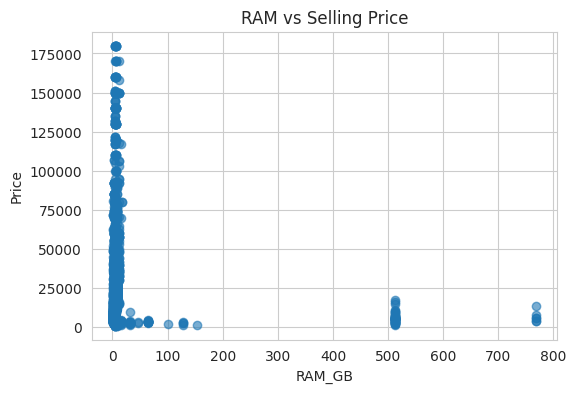

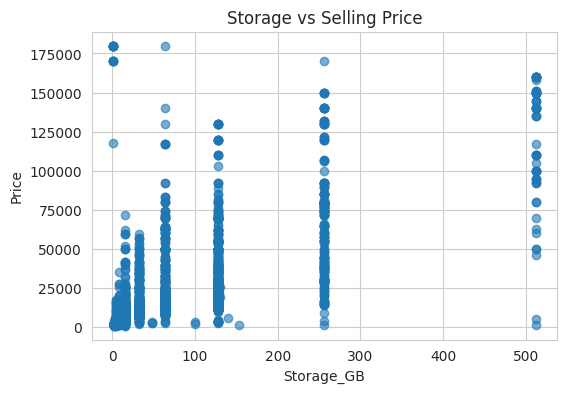

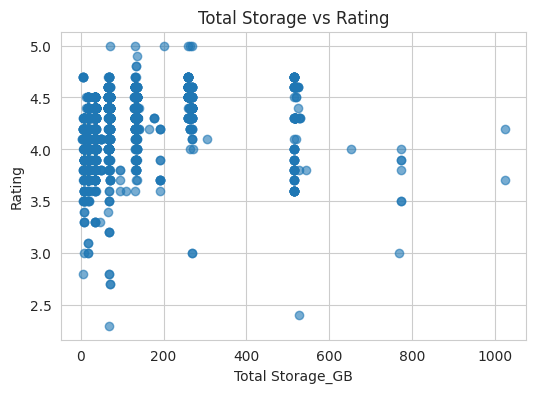

In [13]:
# RAM vs Price
plt.figure(figsize=(6,4))
plt.scatter(df['RAM_GB'], df['Selling Price'], alpha=0.6)
plt.title('RAM vs Selling Price')
plt.xlabel('RAM_GB')
plt.ylabel('Price')
plt.show()

# Storage vs Price
plt.figure(figsize=(6,4))
plt.scatter(df['Storage_GB'], df['Selling Price'], alpha=0.6)
plt.title('Storage vs Selling Price')
plt.xlabel('Storage_GB')
plt.ylabel('Price')
plt.show()

# Total Storage vs Rating
plt.figure(figsize=(6,4))
plt.scatter(df['total_storage_GB'], df['Rating'], alpha=0.6)
plt.title('Total Storage vs Rating')
plt.xlabel('Total Storage_GB')
plt.ylabel('Rating')
plt.show()

# KMeans-кластеризация

Silhouette score: 0.7700172251921391


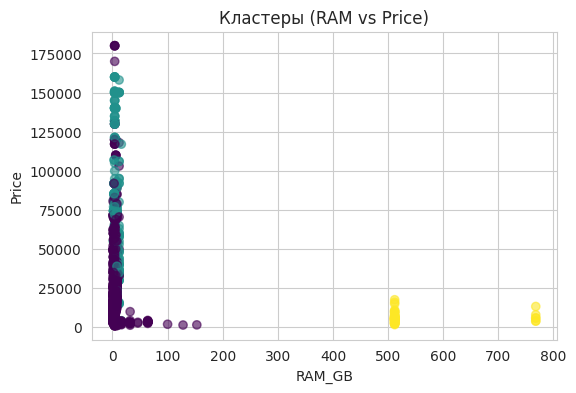

In [14]:
X = df[['RAM_GB','Storage_GB','Rating','value_score']].copy()

# Вариант A: удалить строки с NaN
# Вариант B: заполнить медианой

X.dropna(inplace=True)
df = df.loc[X.index]

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
df['cluster'] = labels

print("Silhouette score:", silhouette_score(X, labels))

plt.figure(figsize=(6,4))
plt.scatter(df['RAM_GB'], df['Selling Price'], c=labels, cmap='viridis', alpha=0.6)
plt.title('Кластеры (RAM vs Price)')
plt.xlabel('RAM_GB')
plt.ylabel('Price')
plt.show()

# Выводы
1. Добавленные признаки помогли разделить данные
2. После очистки исчезли дубликаты и выбросы
3. На графиках выделяются три сегмента: бюджетный, средний и премиум
4. Силуэт 0.77 указывает на хорошую разделённость кластеров